In [1]:
import mmengine
import mmcv
from mmcv.transforms import Compose, Resize
import matplotlib.pyplot as plt
from mmdet.utils import get_test_pipeline_cfg
import torch
import numpy as np
import torchvision.transforms as torch_trans
from mmdet.apis import init_detector, inference_detector 
from wrappers import *
from mmdet.visualization import DetLocalVisualizer
from mmengine.registry import MODELS
from mmengine.config import Config

In [2]:
# model_path = "configs/swin/swin_tiny.py"
model_path = "configs/swin/swin_moe.py"
ckpt_path = "weights/epoch_24.pth"
cfg = Config.fromfile(model_path)
model = init_detector(cfg)
# model = MODELS.build(cfg.model)

vis = DetLocalVisualizer()
palette = [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (0, 200, 30), (100, 200, 150), (100, 200, 50), (10, 200, 50)]
CLASSES = ('1','2','3','4','5','6')
img = mmcv.imread("data/mmdet/NEU_DET/test/inclusion_251.jpg")

False
False
False
False
False
False
False
False
False
False
False
True


/home/huemorgen/Defect-Detection/packages/mmdetection/mmdet/apis/inference.py:70: UserWarning: checkpoint is None, use COCO classes by default.
  warnings.warn('checkpoint is None, use COCO classes by default.')


In [3]:
model

FasterRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): SwinTransformerMOE(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
        

In [4]:
from mmengine.runner.checkpoint import _load_checkpoint
checkpoint = _load_checkpoint(ckpt_path, 'cpu')
ckp_state_dict = checkpoint['state_dict']
model_state_dict = model.state_dict()


Loads checkpoint by local backend from path: weights/epoch_24.pth


In [5]:
gates = []
for i, key in enumerate(model_state_dict.keys()):
    if 'gate' in key:
        gates.append(key)

In [6]:
gates

['backbone.stages.3.blocks.1.ffn.gate.w_gate.weight',
 'backbone.stages.3.blocks.1.ffn.gate.w_gate.bias']

In [7]:
experts = []
for i, key in enumerate(model_state_dict.keys()):
    if 'experts' in key:
        experts.append(key)

ffn_ckpt = []
for i, key in enumerate(ckp_state_dict.keys()):
    if 'ffn' in key:
        ffn_ckpt.append(key)

In [8]:
experts

['backbone.stages.3.blocks.1.ffn.experts.0.layers.0.0.weight',
 'backbone.stages.3.blocks.1.ffn.experts.0.layers.0.0.bias',
 'backbone.stages.3.blocks.1.ffn.experts.0.layers.1.weight',
 'backbone.stages.3.blocks.1.ffn.experts.0.layers.1.bias',
 'backbone.stages.3.blocks.1.ffn.experts.1.layers.0.0.weight',
 'backbone.stages.3.blocks.1.ffn.experts.1.layers.0.0.bias',
 'backbone.stages.3.blocks.1.ffn.experts.1.layers.1.weight',
 'backbone.stages.3.blocks.1.ffn.experts.1.layers.1.bias',
 'backbone.stages.3.blocks.1.ffn.experts.2.layers.0.0.weight',
 'backbone.stages.3.blocks.1.ffn.experts.2.layers.0.0.bias',
 'backbone.stages.3.blocks.1.ffn.experts.2.layers.1.weight',
 'backbone.stages.3.blocks.1.ffn.experts.2.layers.1.bias',
 'backbone.stages.3.blocks.1.ffn.experts.3.layers.0.0.weight',
 'backbone.stages.3.blocks.1.ffn.experts.3.layers.0.0.bias',
 'backbone.stages.3.blocks.1.ffn.experts.3.layers.1.weight',
 'backbone.stages.3.blocks.1.ffn.experts.3.layers.1.bias']

In [9]:
model_state_dict[experts[0]].shape, ckp_state_dict[ffn_ckpt[-4]].shape

(torch.Size([3072, 768]), torch.Size([3072, 768]))

In [10]:
experts[0]

'backbone.stages.3.blocks.1.ffn.experts.0.layers.0.0.weight'

In [11]:
num_experts = 4
j = 1
ckp_it = iter(ckp_state_dict)
model_it = iter(model_state_dict)
experts_it = iter(experts)
l = 219
it = 0
stop_it = False
while not stop_it:
    model_key = next(model_it)
    print("MODEL")
    print(model_key)
    if 'gate' in model_key:
        model_state_dict[model_key] = torch.nn.Parameter(model_state_dict[model_key])
        print("GATE")
        print(model_state_dict[model_key])
        # model_state_dict[model_key] = torch.rand(model_state_dict[model_key].shape)
        continue
   
    if 'expert' in model_key:
        ws = []
        for i in range(4):
            key = next(ckp_it)
            w = ckp_state_dict[key]
            ws.append(w)
            it+=1
            if it==l:
                stop_it = True
                break
        i = 0
        for _ in range(4*num_experts):
            shape = model_state_dict[model_key].shape
            # shape = [shape[0], shape[1]] if len(shape)==2 else [shape[0]]
            print(shape)
            print(ws[i%4].shape)
            model_state_dict[model_key] = ws[i%4].clone()
            i+=1
            model_key = next(model_it)  
        if 'gate' in model_key:
            model_state_dict[model_key] = torch.nn.Parameter(model_state_dict[model_key])
            print("GATE")
            print(model_state_dict[model_key])
            model_key = next(model_it)
            model_state_dict[model_key] = torch.nn.Parameter(model_state_dict[model_key])
            print("GATE")
            print(model_state_dict[model_key])
            continue
    ckp_key = next(ckp_it)
    print(ckp_key)
    it+=1
    if it==l:
            stop_it = True
            break
    model_state_dict[model_key] = ckp_state_dict[ckp_key].clone()
    


MODEL
backbone.patch_embed.projection.weight
backbone.patch_embed.projection.weight
MODEL
backbone.patch_embed.projection.bias
backbone.patch_embed.projection.bias
MODEL
backbone.patch_embed.norm.weight
backbone.patch_embed.norm.weight
MODEL
backbone.patch_embed.norm.bias
backbone.patch_embed.norm.bias
MODEL
backbone.stages.0.blocks.0.norm1.weight
backbone.stages.0.blocks.0.norm1.weight
MODEL
backbone.stages.0.blocks.0.norm1.bias
backbone.stages.0.blocks.0.norm1.bias
MODEL
backbone.stages.0.blocks.0.attn.w_msa.relative_position_bias_table
backbone.stages.0.blocks.0.attn.w_msa.relative_position_bias_table
MODEL
backbone.stages.0.blocks.0.attn.w_msa.relative_position_index
backbone.stages.0.blocks.0.attn.w_msa.relative_position_index
MODEL
backbone.stages.0.blocks.0.attn.w_msa.qkv.weight
backbone.stages.0.blocks.0.attn.w_msa.qkv.weight
MODEL
backbone.stages.0.blocks.0.attn.w_msa.qkv.bias
backbone.stages.0.blocks.0.attn.w_msa.qkv.bias
MODEL
backbone.stages.0.blocks.0.attn.w_msa.proj.weigh

In [12]:
revise_keys=[(r'^module\.', '')]

In [13]:
from mmengine.runner.checkpoint import _load_checkpoint_to_model
out = _load_checkpoint_to_model(model, model_state_dict, revise_keys)

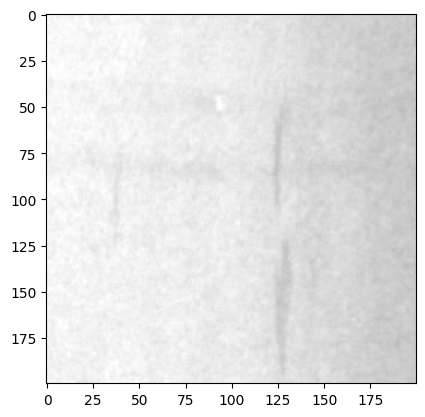

In [14]:
results = inference_detector(model, img)
# print(results.keys())
results.pred_instances.labels = torch.ones_like(results.pred_instances.labels)
results.pred_instances = results.pred_instances.detach().cpu()
output = vis._draw_instances(img, results.pred_instances[results.pred_instances.scores>0.01], classes=CLASSES, palette=palette)
plt.imshow(output)

In [15]:
from mmengine.runner.checkpoint import save_checkpoint
checkpoint_out = dict(state_dict=model_state_dict)
file = 'moe_base_model.pth'
save_checkpoint(checkpoint_out, file)

04/12 19:27:20 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
04/12 19:27:20 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
